In [ ]:
from google.colab import files
uploaded = files.upload()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import tensor
import numpy as np
import torchvision
from torchvision import datasets,transforms,models
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch.optim import Adam, lr_scheduler
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import shutil
import glob
!pip install torchmetrics
import torchmetrics
!pip install patool
import patoolib
import pathlib
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score
from sklearn.model_selection import StratifiedKFold
!pip install deeplake
import deeplake
import subprocess
# !pip install datasets
# from datasets import load_dataset

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class VoltaVision(nn.Module):
    def __init__(self, num_classes=3):
        super(VoltaVision, self).__init__()

        # Input shape = (64, 3, 30, 30)
        # Output size after convolutional layer = (w-f+2p)/s + 1 = (30-3+2)/1 + 1 = 30
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        #Input shape = (64, 12, 30, 30)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()

        # Input shape = (64, 12, 30, 30)
        # Output size after max pooling = 30/2 = 15
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Input shape = (64, 12, 15, 15)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.relu3 = nn.ReLU()
        #shape = (64, 32, 15, 15)

        self.fc = nn.Linear(in_features=15*15*32, out_features=num_classes)

    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)

        output = self.maxpool1(output)

        output = self.conv2(output)
        output = self.relu2(output)

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)

        #reshaping the output to feed into the fully connected layer
        output = output.view(-1, 15*15*32)

        output = self.fc(output)

        return output

In [ ]:
def train_model(model, criterion, optimizer, scheduler,  dataloaders, dataset_sizes, num_epochs=15):
    since = time.time()
    torch.cuda.reset_peak_memory_stats(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # create a list to store the training and validation accuracy values
    train_acc_list = []
    val_acc_list = []

    # create a list to store the training and validation loss values
    train_loss_list = []
    val_loss_list = []

    # initialize metric
    metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=3)
    predicted_labels = []
    ground_truth_labels = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*10)

        #Training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #forward
                #track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #_,preds = torch.max(outputs,1)
                    #loss = criterion(outputs,labels)
                    #googlenetcprfix
                    if str(type(outputs)) == "<class 'torch.Tensor'>":
                        _,preds = torch.max(outputs,1)
                        loss = criterion(outputs,labels)
                    else :
                        _,preds = torch.max(outputs.logits,1)
                        loss = criterion(outputs.logits,labels)

                    #backward + optimize only in train
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_acc_list.append(epoch_acc.item())
                train_loss_list.append(epoch_loss)
            elif phase == 'val':
                val_acc_list.append(epoch_acc.item())
                val_loss_list.append(epoch_loss)

            predicted_labels.append(preds.cpu())
            ground_truth_labels.append(labels.cpu())


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            #deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    #calculate accuracy
    predicted_labels = torch.cat(predicted_labels)
    ground_truth_labels = torch.cat(ground_truth_labels)
    accuracy = Accuracy(task="multiclass", num_classes=3)
    accuracy(predicted_labels, ground_truth_labels)
    print(f'Accuracy: {accuracy.compute():.4f}')

    #calculate precision
    precision = Precision(task="multiclass", average='macro', num_classes=3)
    precision(predicted_labels, ground_truth_labels)
    print(f'Precision: {precision.compute():.4f}')

    #calculate recall
    recall = Recall(task="multiclass", average='macro', num_classes=3)
    recall(predicted_labels, ground_truth_labels)
    print(f'Recall: {recall.compute():.4f}')

    #calculate f1 score
    f1 = F1Score(task="multiclass", average='macro', num_classes=3)
    f1(predicted_labels, ground_truth_labels)
    print(f'F1: {f1.compute():.4f}')

    #calculate confusion matrix
    cm = torchmetrics.functional.confusion_matrix(predicted_labels, ground_truth_labels, num_classes=3, task="multiclass")
    print(f'Confusion Matrix: \n{cm}')

    #plot the training and validation accuracy
    plt.figure(figsize=(10, 6))

    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

    #plot the training and validation loss

    plt.figure(figsize=(10, 6))

    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

    metrics = {}
    metrics['accuracy'] = accuracy.compute()
    metrics['precision'] = precision.compute()
    metrics['recall'] = recall.compute()
    metrics['f1'] = f1.compute()
    metrics['time'] = time_elapsed
    metrics['memory'] = torch.cuda.max_memory_allocated()/(1024*1024)


    #load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics


def print_metrics(metrics):
#   total_time = metrics["time"]*5
  print(f'Average accuracy: {metrics["accuracy"]:.4f}')
  print(f'Average precision: {metrics["precision"]:.4f}')
  print(f'Average recall: {metrics["recall"]:.4f}')
  print(f'Average F1 score: {metrics["f1"]:.4f}')
  print(f'Average Time elapsed: {metrics["time"]:.4f} seconds')
  print(f'Memory Usage: {metrics["memory"]:.4f} MiB')


def get_transforms(model_name):

  # resize_transform = transforms.Resize(224, interpolation=InterpolationMode.BILINEAR)
  # resize_transform = transforms.Resize(224, interpolation=InterpolationMode.BICUBIC)
  # resize_transform = transforms.Resize(224, interpolation=InterpolationMode.NEAREST)

  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.225])
  if model_name in ['googlenet', 'resnet18', 'alexnet']:
      data_transforms = {
          'train':transforms.Compose([
              transforms.RandomResizedCrop(224, interpolation=InterpolationMode.NEAREST),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ]),
          'val':transforms.Compose([
              transforms.Resize(256, interpolation=InterpolationMode.NEAREST),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ])
      }
  elif model_name == 'inceptionv3':
      data_transforms = {
          'train':transforms.Compose([
              transforms.Resize((299, 299)),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ]),
          'val':transforms.Compose([
              transforms.Resize((299, 299)),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ])
      }
  elif model_name == 'vgg16':
      data_transforms = {
          'train':transforms.Compose([
              transforms.Resize(224),
              transforms.CenterCrop(224),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ]),
          'val':transforms.Compose([
              transforms.Resize(224),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ])
      }
  else:
    data_transforms = {
        'train':transforms.Compose([
            transforms.Resize((30, 30)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)  # Normalize all three channels
        ]),
        'val':transforms.Compose([
            transforms.Resize((30, 30)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)  # Normalize all three channels
        ])
    }
  return data_transforms

#returns pretrained model trained on ImageNet dataset
def get_pretrained_model(model_name, num_classes, pretrained, device='cpu', weights=None):
  if pretrained == True:
      if model_name == 'googlenet':
          return models.googlenet(pretrained=True)
      elif model_name == 'inceptionv3':
          return models.inception_v3(pretrained=True)
      elif model_name == 'vgg16':
          return models.vgg16(pretrained=True)
      elif model_name == 'resnet18':
          return models.resnet18(pretrained=True)
      elif model_name == 'alexnet':
          return models.alexnet(pretrained=True)
      else:
          #load voltavision here.
          raise ValueError(f"Invalid model_name: {model_name}")
  else:
    if model_name == 'googlenet':
        return models.googlenet(weights=weights).to(device)
    elif model_name == 'inceptionv3':
        return models.inception_v3(weights=weights).to(device)
    elif model_name == 'vgg16':
        return models.vgg16(weights=weights).to(device)
    elif model_name == 'resnet18':
        return models.resnet18(weights=weights).to(device)
    elif model_name == 'alexnet':
        return models.alexnet(weights=weights).to(device)
    elif model_name == 'voltavision':
        return VoltaVision(num_classes).to(device)
    else:
        raise ValueError(f"Invalid model_name: {model_name}")



In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, ds, transform = None):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        image = self.ds.images[idx].numpy()
        label = self.ds.labels[idx].numpy(fetch_chunks = False).astype(np.int32)

        if self.transform is not None:
            image = self.transform(image)

        sample = {"images": image, "labels": label}

        return sample

In [ ]:
def build_preTrain(model_name, num_classes, dataset="cifar100"):
  #hub://activeloop/tiny-imagenet-validation
  ds_train = deeplake.load("hub://activeloop/"+dataset+"-train")
  ds_val = deeplake.load("hub://activeloop/"+dataset+"-test")

  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.225])

  transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((30, 30)),  # Resize first for efficiency
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Handle grayscale if needed
    transforms.Normalize(mean, std)  # Normalize all three channels
  ])

  train_set = ClassificationDataset(ds_train, transform = transform)
  val_set = ClassificationDataset(ds_val, transform = transform)

  train_dataloader = DataLoader(train_set, batch_size = 64, num_workers = 0, shuffle = True)
  test_dataloader = DataLoader(val_set, batch_size = 64, num_workers = 0, shuffle = True)

  train_count = len(ds_train)
  test_count = len(ds_val)

  print('train_count: ', train_count)
  print('test_count: ', test_count)

  pretrained_model = get_pretrained_model(model_name, num_classes, False, device)


  if model_name in ['googlenet', 'resnet18', 'inceptionv3', 'voltavision']:
    pretrained_model.fc = nn.Linear(in_features=pretrained_model.fc.in_features, out_features=num_classes, device=device)
  elif model_name in ['alexnet', 'vgg16']:
    num_ftrs = pretrained_model.classifier[6].in_features
    pretrained_model.classifier[6] = nn.Linear(num_ftrs, num_classes, device=device)
  else:
    raise ValueError(f"Invalid model_name: {model_name}")


  # Loss and optimizer
  optimizer = Adam(pretrained_model.parameters(), lr=0.001, weight_decay=0.0001)
  loss_fn = nn.CrossEntropyLoss()
  scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

  #training the model and saving best model
  num_epochs = 10
  best_accuracy = 0.0

  for epoch in range(num_epochs):
    #Evaluation and training on training dataset
    pretrained_model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, data in enumerate(train_dataloader):
      # print(data)
      if torch.cuda.is_available():
          images = Variable(data['images'].cuda())
          labels = Variable(data['labels'].cuda())
          labels = torch.argmax(labels, dim=1)


      optimizer.zero_grad()

      outputs = pretrained_model(images)
      if str(type(outputs)) != "<class 'torch.Tensor'>":
        outputs_logits = outputs.logits
      else:
        outputs_logits = outputs
      loss = loss_fn(outputs_logits, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.cpu().data*images.size(0)
      _, prediction = torch.max(outputs_logits, 1)

      train_accuracy += int(torch.sum(prediction==labels))

    train_accuracy = train_accuracy/train_count
    train_loss = train_loss/train_count

    #Evaluation on testing dataset
    pretrained_model.eval()
    test_accuracy = 0.0
    for i, (images, labels) in enumerate(test_dataloader):
        if torch.cuda.is_available():
            images = Variable(data['images'].cuda())
            labels = Variable(data['labels'].cuda())

        outputs = pretrained_model(images)
        _, prediction = torch.max(outputs.data, 1)
        test_accuracy += int(torch.sum(prediction==labels))

    test_accuracy = test_accuracy/test_count

    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))

    #Save the best model
    if test_accuracy > best_accuracy:
        torch.save(pretrained_model.state_dict(), 'best_'+model_name+'_checkpoint.model')
        best_accuracy = test_accuracy

    scheduler.step()

In [ ]:
def preTrainCPR(model_name, pretrain_num_classes, classes, dataset="cifar100"):
  # build_preTrain(model_name, pretrain_num_classes, dataset)
  data_transforms = get_transforms(model_name)
  # Get a list of all image filenames and corresponding labels
  all_filenames = []
  all_labels = []
  # Iterate through each class folder and associate each image with corresponding lable
  for class_name in classes:
      class_folder = os.path.join(folder_path, class_name)
      class_filenames = [os.path.join(class_folder, filename) for filename in os.listdir(class_folder)]

      # Extend the list of all_filenames and all_labels
      all_filenames.extend(class_filenames)
      all_labels.extend([class_name] * len(class_filenames))

  # Use StratifiedKFold for creating folds
  num_folds = 5
  stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

  all_metrics = []

  # Perform stratified k-fold cross-validation
  for i, (train_idx, test_idx) in enumerate(stratified_kfold.split(all_filenames, all_labels)):
      train_FileNames = [all_filenames[idx] for idx in train_idx]
      val_FileNames = [all_filenames[idx] for idx in test_idx]
      print('Fold: ',i)
      print('Training: ', len(train_FileNames))
      print('Validation: ', len(val_FileNames))
      fold_dir = f'./splitted_dataset/fold{i}'
      if not os.path.exists(fold_dir):
          os.makedirs(fold_dir+'/train')
          os.makedirs(fold_dir+'/val')

          # Creating the class folders in train and validation folders
          for class_name in classes:
              os.makedirs(fold_dir+'/train/' + class_name)
              os.makedirs(fold_dir+'/val/' + class_name)

      for name in train_FileNames:
          class_name = name.split('/')[1]
          shutil.copy(name, fold_dir+'/train/' + class_name)
      for name in val_FileNames:
          class_name = name.split('/')[1]
          shutil.copy(name, fold_dir+'/val/' + class_name)


      sets = ['train','val']
      image_datasets = {x:datasets.ImageFolder(os.path.join(fold_dir,x),
                                              data_transforms[x])
                      for x in ['train','val']}
      dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,
                                                  shuffle=True,num_workers=0)
                      for x in ['train','val']}

      dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}


      #pretrained_model = get_pretrained_model(model_name, True)
      # loading the skeleton
      pretrained_model = get_pretrained_model(model_name, pretrain_num_classes, False, device)

      if model_name in ['googlenet', 'resnet18', 'voltavision', 'inceptionv3']:
        pretrained_model.fc = nn.Linear(in_features=pretrained_model.fc.in_features, out_features=pretrain_num_classes, device=device)
      elif model_name in ['alexnet', 'vgg16']:
        num_ftrs = pretrained_model.classifier[6].in_features
        pretrained_model.classifier[6] = nn.Linear(num_ftrs, pretrain_num_classes)
      else:
        raise ValueError(f"Invalid model_name: {model_name}")



      #load the best_checkpoint.model
      checkpoint = torch.load('best_'+model_name+'_checkpoint.model')
      pretrained_model.load_state_dict(checkpoint)

      #freezing previous layers
      for param in pretrained_model.parameters():
        param.requires_grad = False

      num_classes = 3
      #pretrained_model_CPR.fc = nn.Linear(in_features=pretrained_model_CPR.fc.in_features, out_features=num_classes, device=device)
      if model_name in ['googlenet', 'resnet18', 'voltavision', 'inceptionv3']:
        pretrained_model.fc = nn.Linear(in_features=pretrained_model.fc.in_features, out_features=num_classes, device=device)
      elif model_name in ['alexnet', 'vgg16']:
        num_ftrs = pretrained_model.classifier[6].in_features
        pretrained_model.classifier[6] = nn.Linear(num_ftrs, num_classes)
      else:
        raise ValueError(f"Invalid model_name: {model_name}")

      pretrained_model.to(device)

      criterion = nn.CrossEntropyLoss()
      optimizer = optim.SGD(pretrained_model.parameters(),lr=0.001)

      #scheduler
      step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

      model_ft, metrics = train_model(pretrained_model,criterion,optimizer,step_lr_scheduler, dataloaders, dataset_sizes,num_epochs=25)
      all_metrics.append(metrics)

  avg_metrics = {key: np.mean([m[key] for m in all_metrics]) for key in all_metrics[0]}
  print_metrics(avg_metrics)

In [ ]:
if not os.path.exists('./THB_dataset'):
    patoolib.extract_archive('THB_dataset.zip')

INFO patool: Extracting THB_dataset.zip ...
INFO:patool:Extracting THB_dataset.zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_jndsl9ji -- THB_dataset.zip
INFO:patool:running /usr/bin/7z x -o./Unpack_jndsl9ji -- THB_dataset.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... THB_dataset.zip extracted to `THB_dataset'.
INFO:patool:... THB_dataset.zip extracted to `THB_dataset'.


In [ ]:
folder_path = 'THB_dataset'
classes = os.listdir(folder_path)
print(classes)

['Transistor', 'Bluetooth', 'Humidity']


Fold:  0
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 1.0667 Acc: 0.4389
val Loss: 0.9726 Acc: 0.4394

Epoch 1/24
----------
train Loss: 0.9521 Acc: 0.5992
val Loss: 0.8649 Acc: 0.7273

Epoch 2/24
----------
train Loss: 0.8716 Acc: 0.6641
val Loss: 0.8024 Acc: 0.6515

Epoch 3/24
----------
train Loss: 0.8029 Acc: 0.7214
val Loss: 0.7368 Acc: 0.7727

Epoch 4/24
----------
train Loss: 0.7882 Acc: 0.6985
val Loss: 0.7069 Acc: 0.7879

Epoch 5/24
----------
train Loss: 0.7744 Acc: 0.7061
val Loss: 0.7284 Acc: 0.6364

Epoch 6/24
----------
train Loss: 0.7010 Acc: 0.7481
val Loss: 0.6486 Acc: 0.9091

Epoch 7/24
----------
train Loss: 0.6964 Acc: 0.8053
val Loss: 0.6469 Acc: 0.8333

Epoch 8/24
----------
train Loss: 0.6848 Acc: 0.8015
val Loss: 0.6443 Acc: 0.8485

Epoch 9/24
----------
train Loss: 0.6631 Acc: 0.8206
val Loss: 0.6474 Acc: 0.8939

Epoch 10/24
----------
train Loss: 0.6836 Acc: 0.8130
val Loss: 0.6452 Acc: 0.8636

Epoch 11/24
----------
train Loss: 0.6798 Acc:

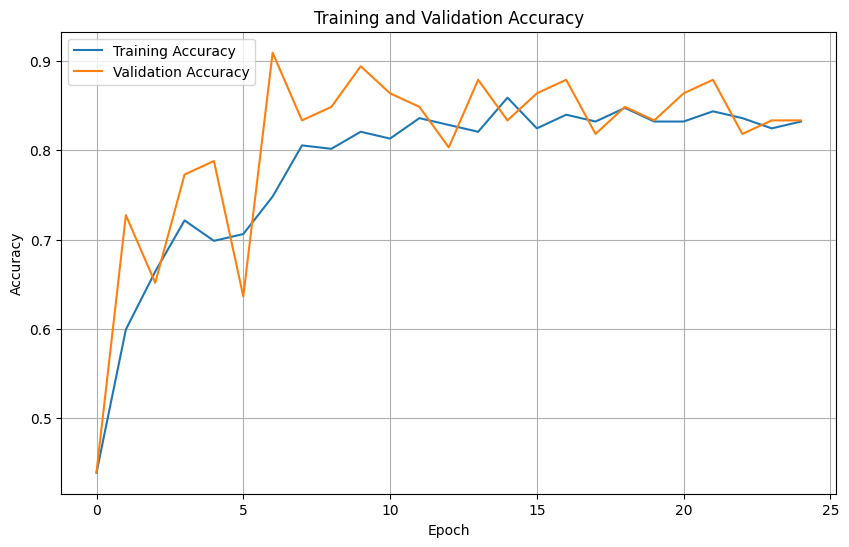

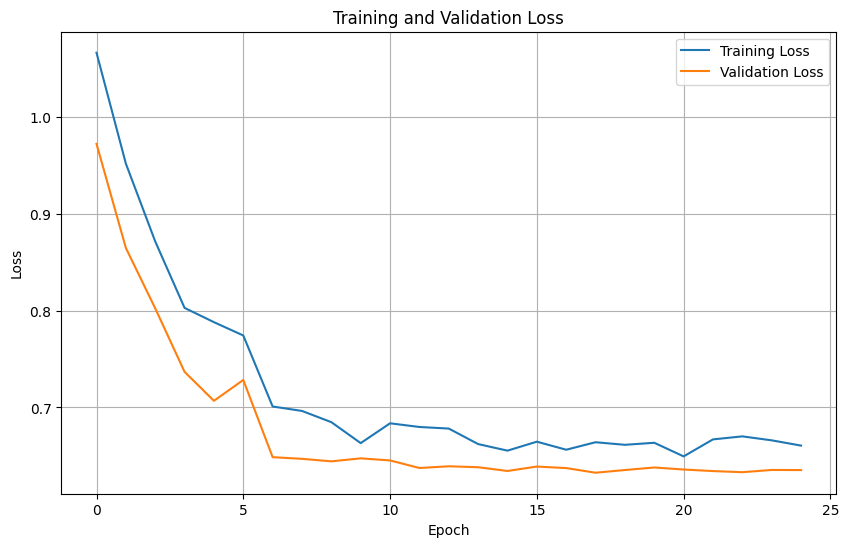

Fold:  1
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 1.0457 Acc: 0.4580
val Loss: 1.0233 Acc: 0.3333

Epoch 1/24
----------
train Loss: 0.9413 Acc: 0.5916
val Loss: 0.9258 Acc: 0.6364

Epoch 2/24
----------
train Loss: 0.8853 Acc: 0.6298
val Loss: 0.8448 Acc: 0.6515

Epoch 3/24
----------
train Loss: 0.8261 Acc: 0.6527
val Loss: 0.8230 Acc: 0.6667

Epoch 4/24
----------
train Loss: 0.7765 Acc: 0.7481
val Loss: 0.7468 Acc: 0.6818

Epoch 5/24
----------
train Loss: 0.7590 Acc: 0.7023
val Loss: 0.7167 Acc: 0.7576

Epoch 6/24
----------
train Loss: 0.7052 Acc: 0.7710
val Loss: 0.7229 Acc: 0.6667

Epoch 7/24
----------
train Loss: 0.6957 Acc: 0.7634
val Loss: 0.6882 Acc: 0.7121

Epoch 8/24
----------
train Loss: 0.6904 Acc: 0.7786
val Loss: 0.6812 Acc: 0.7121

Epoch 9/24
----------
train Loss: 0.6722 Acc: 0.7786
val Loss: 0.6799 Acc: 0.7121

Epoch 10/24
----------
train Loss: 0.6638 Acc: 0.8053
val Loss: 0.6796 Acc: 0.7273

Epoch 11/24
----------
train Loss: 0.6707 Acc:

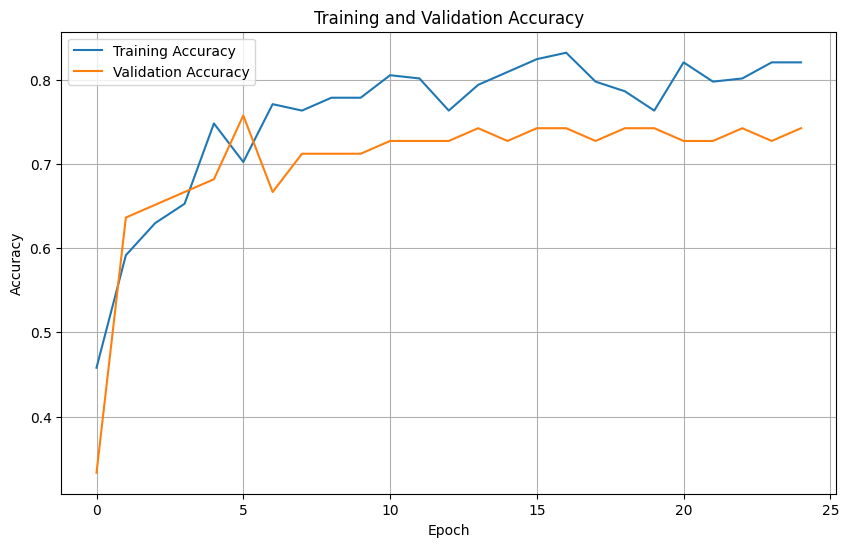

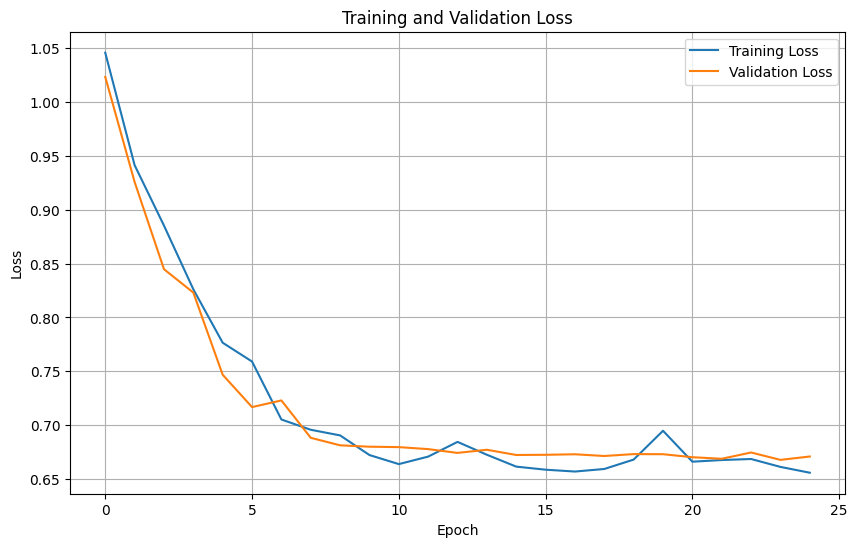

Fold:  2
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 1.0709 Acc: 0.4313
val Loss: 0.9935 Acc: 0.5909

Epoch 1/24
----------
train Loss: 0.9877 Acc: 0.5496
val Loss: 0.9088 Acc: 0.5909

Epoch 2/24
----------
train Loss: 0.9131 Acc: 0.6221
val Loss: 0.8758 Acc: 0.5455

Epoch 3/24
----------
train Loss: 0.8622 Acc: 0.6260
val Loss: 0.7740 Acc: 0.7727

Epoch 4/24
----------
train Loss: 0.7922 Acc: 0.7252
val Loss: 0.7186 Acc: 0.7576

Epoch 5/24
----------
train Loss: 0.7676 Acc: 0.7176
val Loss: 0.6977 Acc: 0.7576

Epoch 6/24
----------
train Loss: 0.7224 Acc: 0.7137
val Loss: 0.6528 Acc: 0.8030

Epoch 7/24
----------
train Loss: 0.6866 Acc: 0.8130
val Loss: 0.6527 Acc: 0.7576

Epoch 8/24
----------
train Loss: 0.6951 Acc: 0.7901
val Loss: 0.6459 Acc: 0.7879

Epoch 9/24
----------
train Loss: 0.6760 Acc: 0.8206
val Loss: 0.6437 Acc: 0.7727

Epoch 10/24
----------
train Loss: 0.6849 Acc: 0.8092
val Loss: 0.6399 Acc: 0.7879

Epoch 11/24
----------
train Loss: 0.6804 Acc:

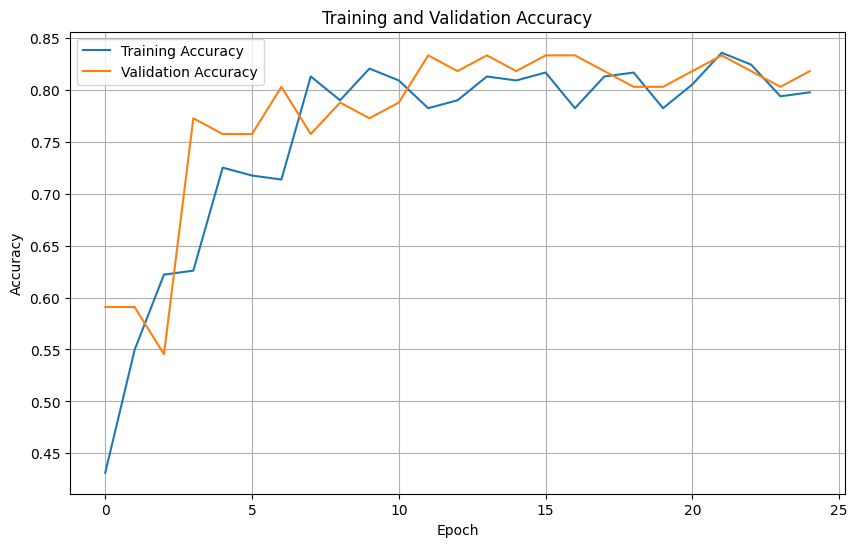

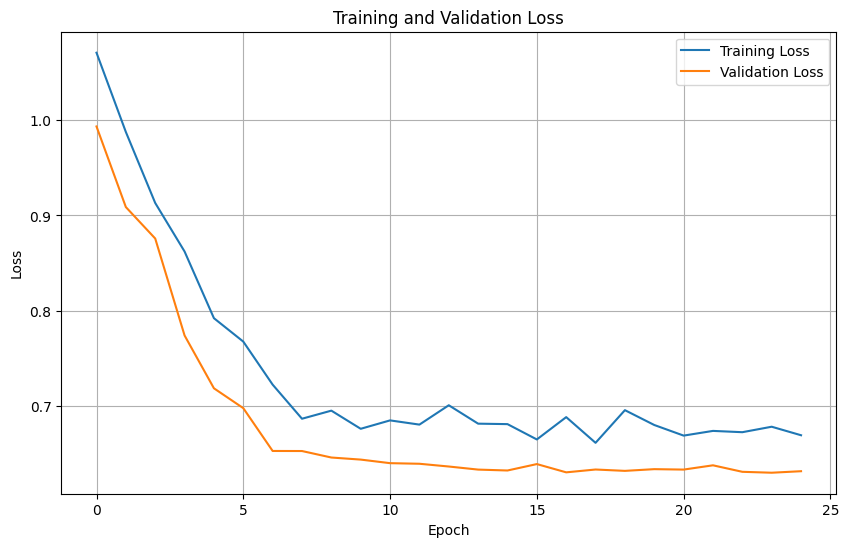

Fold:  3
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 1.0712 Acc: 0.4297
val Loss: 1.0257 Acc: 0.3538

Epoch 1/24
----------
train Loss: 0.9695 Acc: 0.5551
val Loss: 0.9154 Acc: 0.5846

Epoch 2/24
----------
train Loss: 0.9234 Acc: 0.5856
val Loss: 0.8339 Acc: 0.6923

Epoch 3/24
----------
train Loss: 0.8334 Acc: 0.6692
val Loss: 0.7925 Acc: 0.6923

Epoch 4/24
----------
train Loss: 0.7844 Acc: 0.7148
val Loss: 0.7566 Acc: 0.7538

Epoch 5/24
----------
train Loss: 0.7488 Acc: 0.7072
val Loss: 0.7198 Acc: 0.7846

Epoch 6/24
----------
train Loss: 0.7355 Acc: 0.7567
val Loss: 0.7124 Acc: 0.7538

Epoch 7/24
----------
train Loss: 0.6804 Acc: 0.8023
val Loss: 0.6966 Acc: 0.7692

Epoch 8/24
----------
train Loss: 0.6608 Acc: 0.8479
val Loss: 0.6992 Acc: 0.7692

Epoch 9/24
----------
train Loss: 0.6726 Acc: 0.8251
val Loss: 0.6912 Acc: 0.7692

Epoch 10/24
----------
train Loss: 0.6624 Acc: 0.8327
val Loss: 0.6962 Acc: 0.7846

Epoch 11/24
----------
train Loss: 0.6654 Acc:

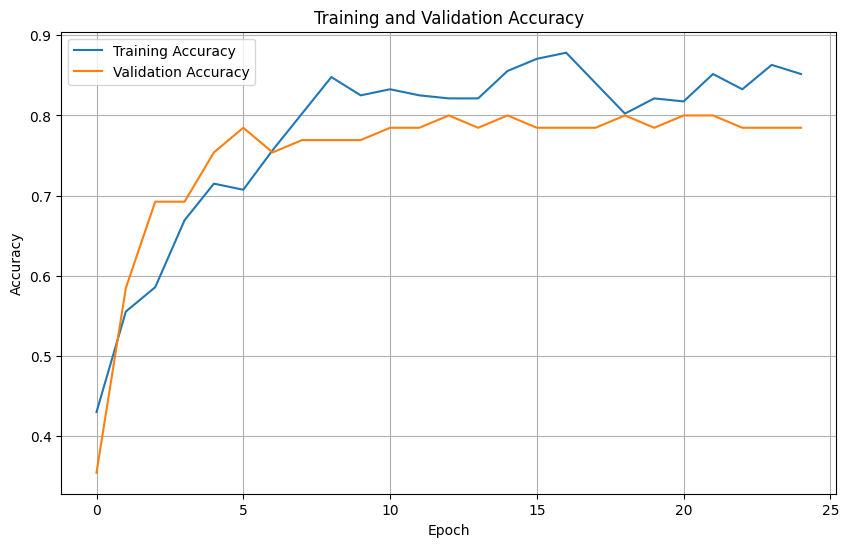

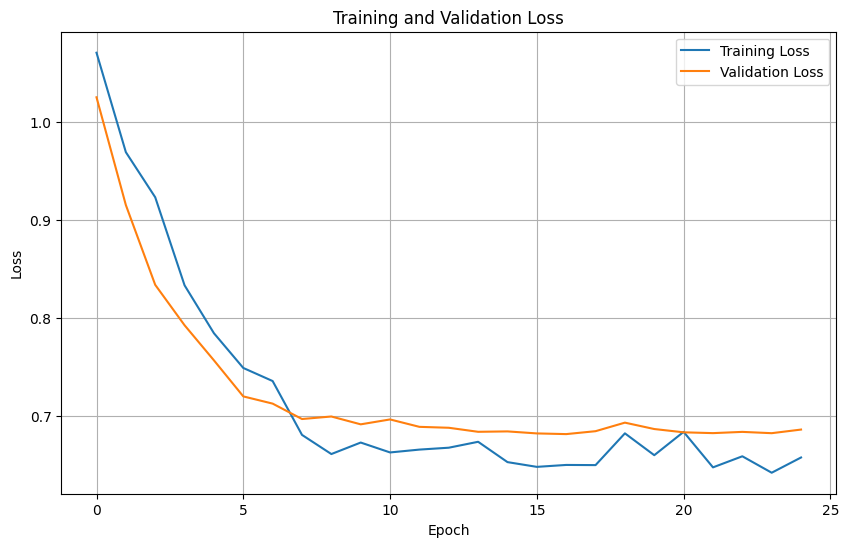

Fold:  4
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 1.0753 Acc: 0.4411
val Loss: 0.9731 Acc: 0.6462

Epoch 1/24
----------
train Loss: 0.9566 Acc: 0.5817
val Loss: 0.9039 Acc: 0.6154

Epoch 2/24
----------
train Loss: 0.8902 Acc: 0.6160
val Loss: 0.8356 Acc: 0.7385

Epoch 3/24
----------
train Loss: 0.8318 Acc: 0.6882
val Loss: 0.7803 Acc: 0.7231

Epoch 4/24
----------
train Loss: 0.7658 Acc: 0.7300
val Loss: 0.7294 Acc: 0.7692

Epoch 5/24
----------
train Loss: 0.7244 Acc: 0.7529
val Loss: 0.7232 Acc: 0.7231

Epoch 6/24
----------
train Loss: 0.7271 Acc: 0.7529
val Loss: 0.6926 Acc: 0.7077

Epoch 7/24
----------
train Loss: 0.6983 Acc: 0.7110
val Loss: 0.6677 Acc: 0.8000

Epoch 8/24
----------
train Loss: 0.6864 Acc: 0.7795
val Loss: 0.6657 Acc: 0.7538

Epoch 9/24
----------
train Loss: 0.6772 Acc: 0.8061
val Loss: 0.6624 Acc: 0.7692

Epoch 10/24
----------
train Loss: 0.6667 Acc: 0.8175
val Loss: 0.6594 Acc: 0.7846

Epoch 11/24
----------
train Loss: 0.6775 Acc:

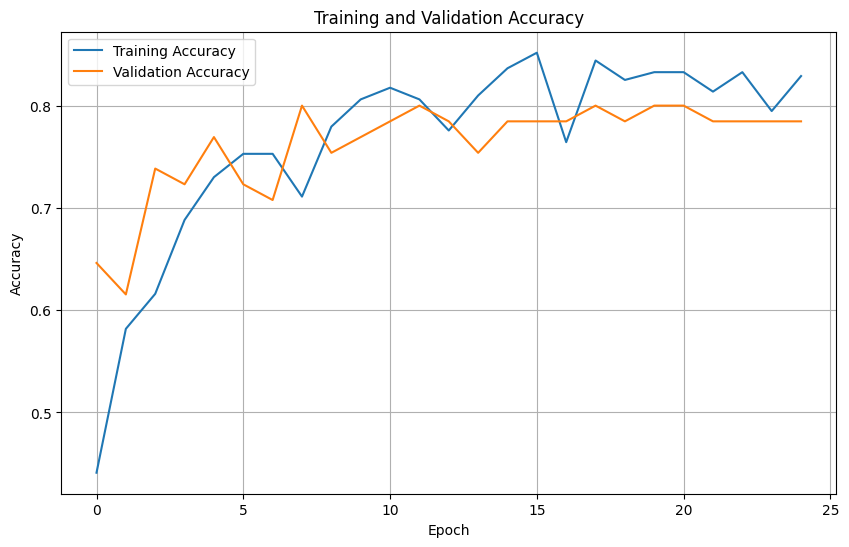

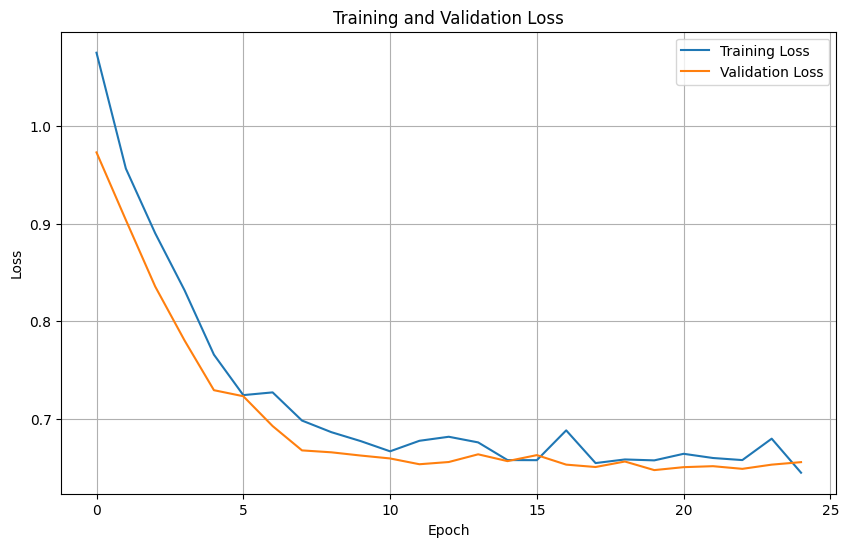

Average accuracy: 0.7580
Average precision: 0.7785
Average recall: 0.7537
Average F1 score: 0.7530
Time elapsed: 274.7900 seconds
Memory Usage: 31.3598 MiB


In [ ]:
preTrainCPR("voltavision", 10, classes, "cifar10")